In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pylab as plt
import seaborn as sns
import ast
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn

# Read Data

In [3]:
IMAGE_LOC = '/nvme/UCIAccData/'

In [4]:
activity_list = [i for i in glob.glob(f'{IMAGE_LOC}/*') if i.find('_') > 0]

In [5]:
activity_list

['/nvme/UCIAccData/Descend_stairs',
 '/nvme/UCIAccData/Use_telephone',
 '/nvme/UCIAccData/Standup_chair',
 '/nvme/UCIAccData/Standup_chair_MODEL',
 '/nvme/UCIAccData/Pour_water',
 '/nvme/UCIAccData/Comb_hair',
 '/nvme/UCIAccData/Walk_MODEL',
 '/nvme/UCIAccData/Pour_water_MODEL',
 '/nvme/UCIAccData/Sitdown_chair',
 '/nvme/UCIAccData/Eat_meat',
 '/nvme/UCIAccData/Climb_stairs',
 '/nvme/UCIAccData/Climb_stairs_MODEL',
 '/nvme/UCIAccData/Eat_soup',
 '/nvme/UCIAccData/Liedown_bed',
 '/nvme/UCIAccData/Brush_teeth',
 '/nvme/UCIAccData/Drink_glass',
 '/nvme/UCIAccData/Getup_bed_MODEL',
 '/nvme/UCIAccData/Drink_glass_MODEL',
 '/nvme/UCIAccData/Getup_bed',
 '/nvme/UCIAccData/Sitdown_chair_MODEL']

In [6]:
def read_data(activity_list):
    '''Read files in each activity in activity_list
    Returns dict: key = activity name -> array of numpy arrays of shape (n_observations, 3) = (ax,ay,az)
    '''
    data = {}
    
    for t in activity_list: #loop over each activity type
        activity_name = t.split('/')[-1]
        data[activity_name] = []
    
        filenames = glob.glob(t + '/*')
        
        for f in filenames: #loop over every participants time-series
            df = pd.read_csv(f, sep=' ', header=None)
            
            #ts = np.sqrt((df**2).sum(axis=1)) #magnitude of acceleration vector
            
            data[activity_name].append(np.array(df))
    
    return data

def get_acceleration_timeseries(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of single time-series of acceleration magnitudes
    '''
    
    data_ts = {}
    
    for k in data:
        data_ts[k] = []
        
        for sample in data[k]: #(ax, ay, az)
            data_ts[k].append(np.sqrt((sample**2).sum(axis=1)))
    
    return data_ts

def get_position_velocity(data):
    '''Input: data returned by read_data
    Output: dictionary mapping activity name -> list of displacement and speed time-series
    '''
    
    data_pos_vel = {}
    
    delta_time = 1 #time-step
    
    for k in data:
        data_pos_vel[k] = []
        
        for acc in data[k]:
            #x = x_0 + vt #constant velocity
            #v = u + at #constant acceleration
            #x = x_0 + ut + 1/2 at^2 #constant acceleration

            #discrete time - assume acceleration constant from step {t-1} to {t}
            #v_{t} = v_{t-1} + a_{t-1} t 
            #x_{t} = x_{t-1} + v_{t-1} t + 1/2 a_{t-1} t^2

            #set time t = 1 (unit). variable called delta_time
    
            #need to initialize p = (x,y,z), v = (vx, vy, vz)
            #assume initial position, velocity = 0
            
            pos, vel = np.zeros_like(acc), np.zeros_like(acc)
            
            for t in range(1, acc.shape[0]):
                vel[t] = vel[t-1] + acc[t-1] * delta_time
                
                pos[t] = pos[t-1] + vel[t-1]*delta_time + (1./2)*acc[t-1]*(delta_time**2)
                
                
            pos = np.sqrt((pos**2).sum(axis=1))
            vel = np.sqrt((vel**2).sum(axis=1))
            
            data_pos_vel[k].append((pos, vel))
            
    return data_pos_vel

In [7]:
data = read_data(activity_list)

In [8]:
data_ts = get_acceleration_timeseries(data)

In [9]:
data_pos_vel = get_position_velocity(data)

# Time-series plots

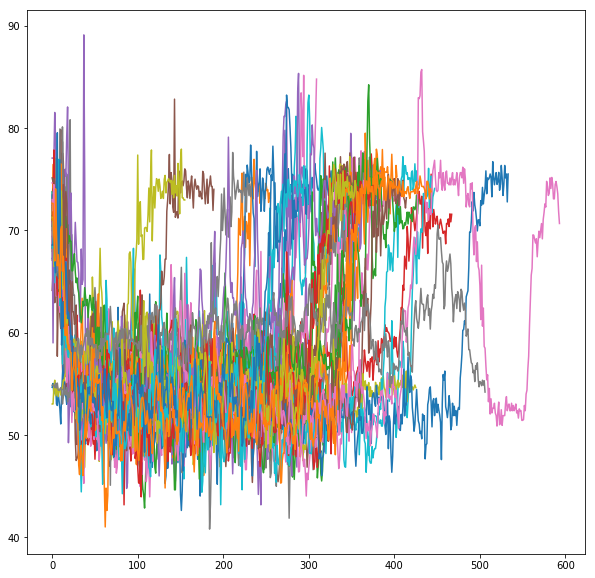

In [10]:
plt.figure(figsize=(10,10))
for elem in data_ts['Descend_stairs']:
    plt.plot(elem)

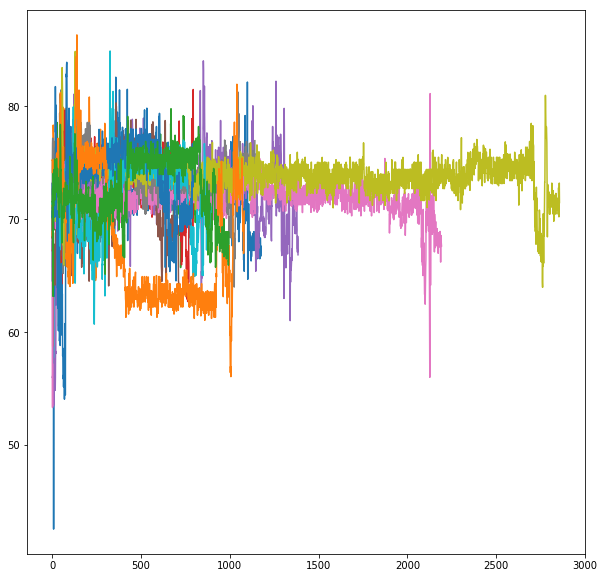

In [11]:
plt.figure(figsize=(10,10))
for elem in data_ts['Use_telephone']:
    plt.plot(elem)

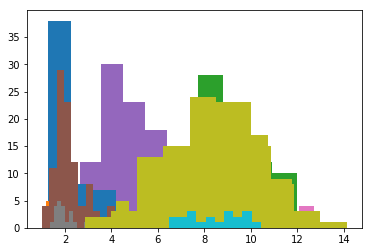

In [12]:
for k in data_ts:
    vols = []
    for val in data_ts[k]:
        vols.append(np.std(val))
        
    plt.hist(vols)

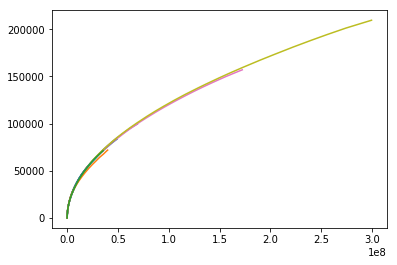

In [13]:
for index, elem in enumerate(data_pos_vel['Use_telephone']):
    plt.plot(elem[0], elem[1])
#for elem in data_pos_vel['Drink_glass']:
#    plt.plot(elem[1])    

In [14]:
#why no negative acc components?
for k in data:
    for elem in data[k]:
        if np.sum(elem < 0) > 0:
            print("Hello")

### Featurizer 1 - statistical properties of acceleration time-series

In [ ]:
def featurize_stats(ts, bins):
    #basic statistical measures
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins) #need faster implementation with overflow/underflow bins
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    features = {'mean_over_median': mean/median, #dimensionless            
                'std_over_median': std/median, #dimensionless            
                'length': length,
                'kurtosis': kurtosis, #already dimensionless by definition
               }
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    return features

In [ ]:
x = featurize_stats(data_ts['Brush_teeth'][0], np.arange(0,100,10))

print(x)

In [ ]:
bins = np.arange(0,100,10)

df = []
labels = []

for k in data_ts: #slow, should parallelize
    for elem in data_ts[k]:
        df.append(featurize_stats(elem, bins))
        labels.append(k)

In [ ]:
df = pd.DataFrame(df)

In [ ]:
df['label'] = labels
df['label'] = df['label'].apply(lambda x: x.replace('_MODEL', ''))

In [ ]:
#dirty, sloppy model - no preprocessing, no train/test etc.
model = LogisticRegression()
model.fit(df.drop('label', axis=1), df['label'])

pred = model.predict(df.drop('label', axis=1))
labels = df['label']

print(np.sum(pred==labels) / len(pred)) #chosen at random, accuracy should be ~1/n_classes = 1/20 = 5%

In [ ]:
model = RandomForestClassifier()

model.fit(df.drop('label', axis=1), df['label'])

pred = model.predict(df.drop('label', axis=1))
labels = df['label']

print(np.sum(pred==labels) / len(pred)) #chosen at random, accuracy should be ~1/n_classes = 1/20 = 5%

In [ ]:
train_df, test_df = train_test_split(df, train_size=0.75)
print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

In [ ]:
model = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=10)

model.fit(train_df.drop('label', axis=1), train_df['label'])

train_pred = model.predict(train_df.drop('label', axis=1))
train_labels = train_df['label']
train_acc = np.sum(train_pred==train_labels) / len(train_pred)

test_pred = model.predict(test_df.drop('label', axis=1))
test_labels = test_df['label']
test_acc = np.sum(test_pred==test_labels) / len(test_pred)

print(f'train acc = {train_acc}, test_acc = {test_acc}')

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()

labels = list(train_df['label'].value_counts().index)

confusion = confusion_matrix(train_labels, train_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_labels, test_pred, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [65]:
#added time-dependent features - redefining function here for convenience (should move to package)
def featurize_stats(ts, bins):
    #basic statistical measures
    mean = np.mean(ts)
    median = np.median(ts)
    std = np.std(ts)
    length = len(ts)
    kurtosis = scipy.stats.kurtosis(ts)
    
    n,b,p = plt.hist(ts, bins=bins) #need faster implementation with overflow/underflow bins
    n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin
    
    features = {'mean_over_median': mean/median, #dimensionless            
                'std_over_median': std/median, #dimensionless            
                'length': length,
                'kurtosis': kurtosis, #already dimensionless by definition
               }
    for i, val in enumerate(n):
        features[f'binfrac_{i}'] = val
    
    #new features
    midpoint = length//2
    
    ts_before = ts[:midpoint]
    ts_after = ts[midpoint:]
    
    mean_before, mean_after = np.mean(ts_before), np.mean(ts_after)
    
    features['mean_over_median_before'] = mean_before/median
    features['mean_over_median_after'] = mean_after/median
    
    return features

def featurize_data(data_ts):
    #featurize
    bins = np.arange(0,100,10)

    df = []
    labels = []

    for k in data_ts: #slow, should parallelize
        for elem in data_ts[k]:
            df.append(featurize_stats(elem, bins))
            labels.append(k)

    df = pd.DataFrame(df)

    df['label'] = labels
    df['label'] = df['label'].apply(lambda x: x.replace('_MODEL', ''))
    
    return df

def create_cv_data(df, train_size=0.75, random_state=None):
    train_df, test_df = train_test_split(df, train_size=train_size, random_state=random_state)
    print(f'train size = {train_df.shape}')
    print(f'test size = {test_df.shape}')

    print(train_df['label'].value_counts())
    print(test_df['label'].value_counts())
    
    return train_df, test_df

def train_sklearn_model(model, train_df, test_df):
    #train model
    model.fit(train_df.drop('label', axis=1), train_df['label'])

    train_pred = model.predict(train_df.drop('label', axis=1))
    train_labels = train_df['label']
    train_acc = np.sum(train_pred==train_labels) / len(train_pred)

    test_pred = model.predict(test_df.drop('label', axis=1))
    test_labels = test_df['label']
    test_acc = np.sum(test_pred==test_labels) / len(test_pred)

    print(f'train acc = {train_acc}, test_acc = {test_acc}')
    
    return model

def plot_confusion_matrix(train_labels, train_pred):
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot()

    labels = list(train_labels.value_counts().index)

    confusion = confusion_matrix(train_labels, train_pred, labels=labels)
    ax.matshow(confusion)

    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))

    ax.set_xticklabels(labels, rotation=90);
    ax.set_yticklabels(labels);

    for i in range(len(labels)):
        for j in range(len(labels)):        
            ax.text(j, i, confusion[i,j], va='center', ha='center')

    plt.xlabel('predicted')    
    plt.ylabel('true')
    
    return fig

In [ ]:
df = featurize_data(data_ts)

In [ ]:
train_df, test_df = create_cv_data(df, train_size=0.75, random_state=10)

In [ ]:
#train model
model = RandomForestClassifier(max_depth=5, n_estimators=100, n_jobs=10)

model = train_sklearn_model(model, train_df, test_df)

In [ ]:
fig = plot_confusion_matrix(train_df['label'], model.predict(train_df.drop('label', axis=1)))

In [ ]:
fig = plot_confusion_matrix(test_df['label'], model.predict(test_df.drop('label', axis=1)))

#### Try feed-forward neural net on features

In [ ]:
cuda_avail = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda_avail else "cpu")

In [ ]:
assert(cuda_avail) #remove this line if no GPU

In [ ]:
class Net(nn.Module):
    def __init__(self, N_input, N_output, N_hidden_layers, N_hidden_nodes):
        super(Net, self).__init__()
        
        #structure of net
        self.in_layer = nn.Linear(N_input, N_hidden_nodes)
        
        self.hidden = nn.ModuleList([])
        for n_layer in range(N_hidden_layers-1):
            self.hidden.append(nn.Linear(N_hidden_nodes, N_hidden_nodes))
        
        self.out_layer = nn.Linear(N_hidden_nodes, N_output)
        
        #activations
        self.activation = nn.ReLU()
        self.output_activation = nn.LogSoftmax()
        
    def forward(self, x): #x is input vector of shape (batch_size, N_features)
        out = self.activation(self.in_layer(x))
        
        for layer in self.hidden:
            out = self.activation(layer(out))
        out = self.output_activation(self.out_layer(out))
        
        return out
    
def train_torch_model(features, label, model, lr, N_epochs, batch_size=None):
    criterion = nn.NLLLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
    if cuda_avail:
        model = model.to(device)
        features = features.to(device)
        label = label.to(device)
        
    #will change to mini-batch training
    for epoch in range(N_epochs):
        out = model(features)
        loss = criterion(out, label)
        
        if epoch % 1000 == 0:
            print(f'epoch = {epoch} loss = {loss}')
        
        optimizer.zero_grad() #set gradients to zero
        loss.backward() #backward propagation to accumulate gradients
        optimizer.step() #gradient descent step
        
    if cuda_avail:
        model = model.to('cpu')
        features = features.to('cpu')
        label = label.to('cpu')
    
    return model

In [ ]:
#DEFINE MODEL
N_input = train_df.shape[1] - 1 #except for labels column
N_output = len(train_df['label'].unique()) #softmax - one for each unique target
N_hidden_layers = 1
N_hidden_nodes = 10

nn_model = Net(N_input, N_output, N_hidden_layers, N_hidden_nodes)

#CONVERT FEATURES, TARGET TO TORCH.TENSORS
train_features = torch.Tensor(np.array(train_df.drop('label', axis=1)))
test_features = torch.Tensor(np.array(test_df.drop('label', axis=1)))

#target should be unique integers for each class
unique_labels = train_df['label'].unique()
labels_to_int_dict = dict(zip(unique_labels, np.arange(len(unique_labels))))
int_to_labels_dict = dict(zip(np.arange(len(unique_labels)), unique_labels))

train_int_labels = train_df['label'].apply(lambda x: labels_to_int_dict[x])
test_int_labels = test_df['label'].apply(lambda x: labels_to_int_dict[x])

train_labels = torch.Tensor(np.array(train_int_labels)).type(torch.LongTensor)
test_labels = torch.Tensor(np.array(test_int_labels)).type(torch.LongTensor)

#TRAIN
N_epochs = 20000
nn_model = train_torch_model(train_features, train_labels, nn_model, 1e-3, N_epochs)

In [ ]:
nn_model(train_features[0])

In [ ]:
N_input = train_df.shape[1] - 1 #except for labels column
N_output = len(train_df['label'].unique()) #softmax - one for each unique target
N_hidden_layers = 1
N_hidden_nodes = 20

nn_model = Net(N_input, N_output, N_hidden_layers, N_hidden_nodes)

features = torch.Tensor(np.array(train_df.drop('label', axis=1)))

unique_labels = train_df['label'].unique()
labels_to_int_dict = dict(zip(unique_labels, np.arange(len(unique_labels))))
int_labels = train_df['label'].apply(lambda x: labels_to_int_dict[x])

labels = torch.Tensor(int_labels).type(torch.LongTensor)

N_epochs = 100000
nnmodel = train_model(features, labels, nn_model, 1e-3, N_epochs)

In [ ]:
train_pred = [int_to_labels_dict[i] for i in torch.argmax(nn_model(train_features), 1).detach().numpy()]
test_pred = [int_to_labels_dict[i] for i in torch.argmax(nn_model(test_features), 1).detach().numpy()]

In [ ]:
train_accuracy = np.sum(train_df['label'] == train_pred) / train_df.shape[0]
test_accuracy = np.sum(test_df['label'] == test_pred) / test_df.shape[0]

In [ ]:
print(f'train acc = {train_accuracy}, test_acc = {test_accuracy}')

In [ ]:
fig = plot_confusion_matrix(train_df['label'], train_pred)
fig = plot_confusion_matrix(test_df['label'], test_pred)

### Featurizer 2 - RNN on raw time-series

In [15]:
data_ts['Descend_stairs'][0][0:5]

array([72.23572523, 69.14477565, 72.23572523, 72.11102551, 68.49817516])

In [34]:
cuda_avail = torch.cuda.is_available()
device = torch.device('cuda:0' if cuda_avail else "cpu")

In [40]:
class RNN(nn.Module):
    '''Very basic architecture - no LSTM cells
    Exactly the same architecture that's used to predict language a last name is in.
    '''
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.inter2hidden = nn.Linear(self.input_size + self.hidden_size, self.hidden_size) #inter_{i} <- hidden_{i-1}, x_{i}
        self.inter2out = nn.Linear(self.input_size + self.hidden_size, self.output_size) #inter_{i} <- hidden_{i-1}, x_{i}
        
        self.activation = nn.ReLU()
        self.output_activation = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden))
        
        hidden = self.inter2hidden(combined)
        
        output = self.inter2out(combined)
        output = self.output_activation(output)
        
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(self.hidden_size)

    
def train_RNN_model(data_ts, model, lr, N_iter, N_batch_size):
    criterion = nn.NLLLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    #get dict mapping labels <-> int
    keys = list(data_ts.keys())
    N_keys = len(keys)
    
    label_to_int = dict(zip(keys, np.arange(N_keys)))
    int_to_label = dict(zip(np.arange(N_keys), keys))
        
    #prepare data
    features, labels, int_labels = [], [], []
    for k in data_ts:
        for elem in data_ts[k]:
            features.append(elem)
            labels.append(k)
            int_labels.append(label_to_int[k])

    #features - have to send each element to gpu
    features = np.array(features)
    int_labels = torch.Tensor(int_labels).reshape(len(int_labels), 1).type(torch.LongTensor)
            
    #model
    if cuda_avail:
        model = model.to(device)
    
    def pick_random_ts():
        random_index = np.random.randint(features.shape[0])
    
        input = features[random_index]    
        int_label = int_labels[random_index]
        
        input = torch.Tensor(input).reshape(len(input), 1)
        int_label = torch.Tensor([int_label]).type(torch.LongTensor)
        
        if cuda_avail:
            input = input.to(device)
            int_label = int_label.to(device)
        
        return input, int_label
    
    #training on single time-series    
    def train_single_example(ts, label):
        hidden = model.init_hidden()
        if cuda_avail:
            hidden = hidden.to(device)
    
        for i in range(ts.size()[0]):
            output, hidden = model(ts[i], hidden)
    
        output = output.reshape(1, len(output))
        
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss
    
    #def pick_random_batch_ts():
    #    np.random.randint()
    
    #train over all examples - WARNING: epoch here is not the usual epoch. it's just number of examples seen 
    cumulative_loss = 0
    counter = 0
    for epoch in range(N_iter):
        counter += 1
        random_ts, random_label = pick_random_ts() #returns torch tensors
        
        loss = train_single_example(random_ts, random_label)
                
        cumulative_loss += loss
        cumulative_mean_loss = cumulative_loss / counter
        
        if epoch % N_batch_size == 0:
            print(f'epoch = {epoch} loss = {loss} cumulative loss = {cumulative_loss} cumulative_mean_loss = {cumulative_mean_loss}]')
            cumulative_loss = 0
            counter = 0
            
    if cuda_avail:
        model = model.to("cpu")
    
    return model, label_to_int, int_to_label

def rnn_predict(model, input):
    hidden = model.init_hidden()
    
    input = torch.Tensor(input).reshape(len(input), 1)
    
    for i in range(input.size()[0]):
        output, hidden = model(input[i], hidden)
    
    return output, hidden

In [29]:
n_hidden = 64
rnn = RNN(1, n_hidden, len(data_ts))

hidden = rnn.init_hidden()

output, hidden = rnn(torch.Tensor([4]), hidden)
print(output.reshape(1, len(output)))

criterion = nn.NLLLoss()
loss = criterion(output.reshape(1, len(output)), torch.Tensor([4]).type(torch.LongTensor))

tensor([[-3.0507, -3.2136, -2.7850, -2.5238, -2.5333, -2.7737, -3.3455, -3.0950,
         -2.9525, -3.4679, -2.8746, -3.4616, -3.3423, -3.2569, -2.9813, -3.0462,
         -2.5789, -3.1500, -3.1326, -3.1562]], grad_fn=<AsStridedBackward>)


/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
#train
#rnn, label_to_int, int_to_label = 
n_hidden = 128
rnn2 = RNN(1, n_hidden, len(data_ts))

#process a total of N_iter time-series, compute loss over each batch. Weight updates are online
rnn3, label_to_int, int_to_label = train_RNN_model(data_ts, rnn2, 1e-3, N_iter=20000, N_batch_size=300)

/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch = 0 loss = 10.325508117675781 cumulative loss = 10.325508117675781 cumulative_mean_loss = 10.325508117675781]


In [60]:
output, hidden = rnn_predict(rnn3, data_ts['Descend_stairs'][0])
print(output)

#int_to_label[torch.argmax(output).detach().numpy()[0]]

int_to_label[torch.argmax(output).item()]

#int_to_labels_dict[i] for i in torch.argmax(nn_model(train_features), 1).detach().numpy()]

tensor([-1.6691, -6.7712, -1.9436, -5.2364, -1.8532, -4.0744, -4.9860, -3.8813,
        -1.4656, -6.3799, -2.2772, -4.3680, -8.8242, -4.2498, -4.4522, -3.2977,
        -6.1252, -4.6527, -3.4200, -5.2252], grad_fn=<LogSoftmaxBackward>)


/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


'Sitdown_chair'

In [61]:
labels, preds = [], []
for k in data_ts:
    for elem in data_ts[k]:
        output, hidden = rnn_predict(rnn3, data_ts['Descend_stairs'][0])
        preds.append(int_to_label[torch.argmax(output).item()])
        labels.append(k)

/home/sanjay/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


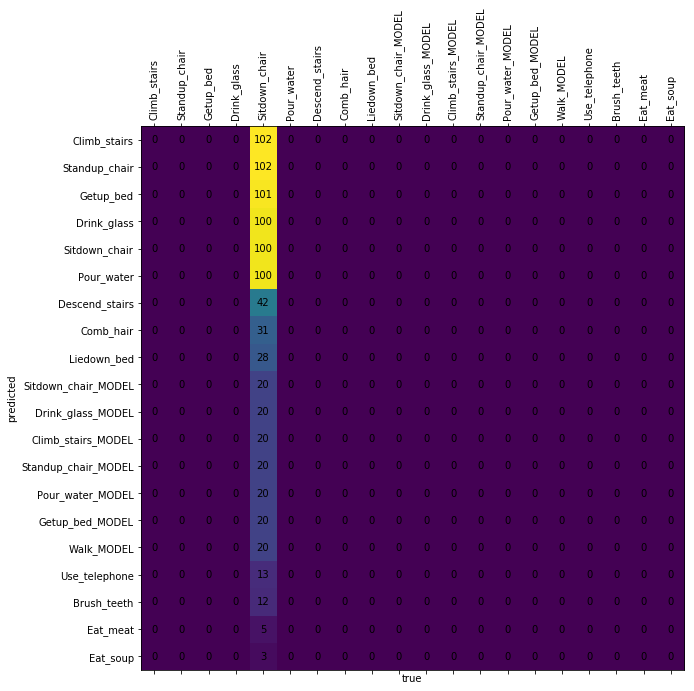

In [73]:
fig = plot_confusion_matrix(pd.Series(labels), pd.Series(preds))

In [72]:
#Yikes! predicting everything to be sitdown chair - need to debug training
pd.Series(labels).value_counts()

Climb_stairs           102
Standup_chair          102
Getup_bed              101
Drink_glass            100
Sitdown_chair          100
Pour_water             100
Descend_stairs          42
Comb_hair               31
Liedown_bed             28
Sitdown_chair_MODEL     20
Drink_glass_MODEL       20
Climb_stairs_MODEL      20
Standup_chair_MODEL     20
Pour_water_MODEL        20
Getup_bed_MODEL         20
Walk_MODEL              20
Use_telephone           13
Brush_teeth             12
Eat_meat                 5
Eat_soup                 3
dtype: int64

### Featurizer 3 - fourier transforms of raw acceleration time-series

### Featurizer 3 - velocity vs position plots

In [ ]:
?plt.hist